# Optimal Growth IV: The Endogenous Grid Method

In [1]:
import numpy as np
import quantecon as qe
from interpolation import interp
from numba import jitclass, njit, float64
from quantecon.optimize import brentq
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:

def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

In [3]:

opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('μ', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                α=0.4, 
                β=0.96, 
                μ=0,
                s=0.1,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.α, self.β, self.μ, self.s = α, β, μ, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))
       

    def f(self, k):
        "The production function"
        return k**self.α
       

    def u(self, c):
        "The utility function"
        return np.log(c)

    def f_prime(self, k):
        "Derivative of f"
        return self.α * (k**(self.α - 1))


    def u_prime(self, c):
        "Derivative of u"
        return 1/c

    def u_prime_inv(self, c):
        "Inverse of u'"
        return 1/c

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  # Remove the CWD from sys.path while we load stuff.


In [4]:
@njit
def K(σ_array, og):
    """
    The Coleman-Reffett operator using EGM

    """

    # Simplify names
    f, β = og.f, og.β
    f_prime, u_prime = og.f_prime, og.u_prime
    u_prime_inv = og.u_prime_inv
    grid, shocks = og.grid, og.shocks

    # Determine endogenous grid
    y = grid + σ_array  # y_i = k_i + c_i

    # Linear interpolation of policy using endogenous grid
    σ = lambda x: interp(y, σ_array, x)

    # Allocate memory for new consumption array
    c = np.empty_like(grid)

    # Solve for updated consumption value
    for i, k in enumerate(grid):
        vals = u_prime(σ(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(β * np.mean(vals))

    return c

In [5]:
og = OptimalGrowthModel()
grid = og.grid

In [6]:
def solve_model_time_iter(model,    # Class with model information
                          σ,        # Initial condition
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

In [7]:
σ_init = np.copy(grid)
σ = solve_model_time_iter(og, σ_init)


Converged in 12 iterations.


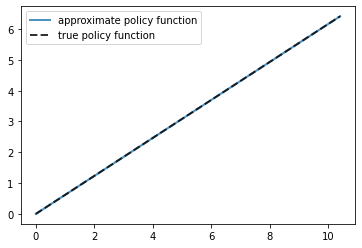

In [8]:
y = grid + σ  # y_i = k_i + c_i

fig, ax = plt.subplots()

ax.plot(y, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(y, σ_star(y, og.α, og.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

In [9]:
np.max(np.abs(σ - σ_star(y, og.α, og.β)))

1.530274914252061e-05

In [10]:
%%timeit -n 3 -r 1
σ = solve_model_time_iter(og, σ_init, verbose=False)

46.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
